In [1]:
import os
os.chdir("../../")

In [27]:
try:
  import GPy
except ModuleNotFoundError:
  %pip install GPy
  import GPy

In [28]:
import flax
from flax import linen as nn
from flax.core import unfreeze

import jax
import jax.numpy as jnp
import optax
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import regression_data
import tensorflow_probability.substrates.jax as tfp

from models.gaussian_mlp import gmlp 
from models.mlp import mlp 
from utilities.fits import fit
from utilities.gmm import gmm_mean_var
from utilities.predict import predict
from utilities import plot

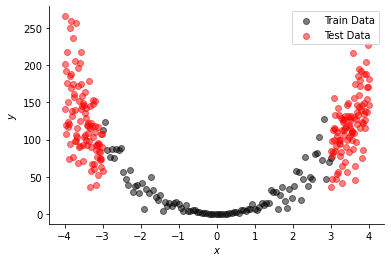

In [30]:
X,y,x_test_1,y_test_1,x_test_2,y_test_2 = regression_data.data_set(n_points=100, poly=True,hetero=True)
plot.plot_actualdata(X,y,x_test_1,y_test_1,x_test_2,y_test_2)

In [31]:
data = pd.DataFrame()
data['X']  = X[:,0]
data['Y'] = y[:,0]
data = data.sort_values(by='X')
X_sorted = data['X'].values.reshape(100,1)
Y_sorted = data['Y'].values.reshape(100,1)


In [32]:
x_stack =jnp.concatenate([x_test_1,X_sorted,x_test_2],axis=0)
y_stack = jnp.concatenate([y_test_1,Y_sorted,y_test_2],axis=0)

## MLP

In [33]:
mlp_model = mlp([32, 64, 32, 1],[nn.relu]*3,[0]*3)

In [34]:
mlp_params = mlp_model.init(jax.random.PRNGKey(0), X, True)

In [35]:
auxs ={
    "X": X,
    "y": y,
    "deterministic" : True
}

In [36]:
mlp_params, mlp_loss = fit(mlp_model, mlp_params, auxs, learning_rate= 0.001, epochs=1000, verbose=True)

Loss step 0:  932.5123
Loss step 100:  172.01459
Loss step 200:  154.2497
Loss step 300:  136.41466
Loss step 400:  111.87239
Loss step 500:  89.93374
Loss step 600:  77.42015
Loss step 700:  71.93011
Loss step 800:  68.205505
Loss step 900:  66.40177


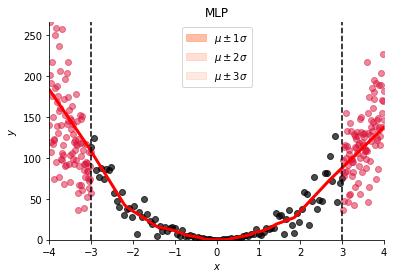

In [37]:
n_points =300
y_hat = mlp_model.apply(mlp_params, x_stack, True)
y_hat = y_hat.reshape(n_points)
plot.plot_prediction(X,y,x_stack,y_stack,y_hat,0,'MLP')

Gaussian MLP

In [117]:
gmlp_model = gmlp(features=[128, 32], activations=[nn.relu]*2, dropout_rate=[0]*2)

In [118]:
# gmlp_model.tabulate(jax.random.PRNGKey(0), X, deterministic=True)

In [119]:
gmlp_params = gmlp_model.init(jax.random.PRNGKey(11), X, True)

In [120]:
auxs ={
    "X": X,
    "y": y,
    "deterministic" : True
}

In [121]:
gmlp_params, loss = fit(gmlp_model, gmlp_params, auxs, learning_rate=0.003, epochs=2000, verbose=True)

Loss step 0:  2266.4602
Loss step 200:  10.876
Loss step 400:  5.9754233
Loss step 600:  4.8376875
Loss step 800:  4.434623
Loss step 1000:  4.198994
Loss step 1200:  4.016248
Loss step 1400:  3.8530536
Loss step 1600:  3.7330213
Loss step 1800:  3.6302013


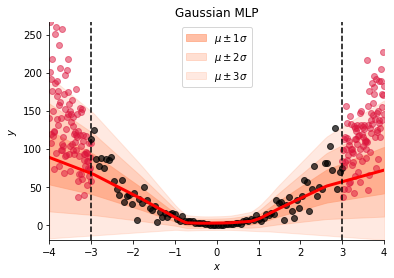

In [122]:
gmlp_mean, gmlp_sigma = gmlp_model.apply(gmlp_params, x_stack, True)
plot.plot_prediction(X, y, x_stack, y_stack, gmlp_mean, gmlp_sigma, "Gaussian MLP")

## MC Dropout Gaussian MLP

In [44]:
mc_model = gmlp(features=[32, 64, 32], activations=[nn.elu]*3, dropout_rate=[0.01]*3)

In [45]:
mc_params = mc_model.init(jax.random.PRNGKey(0), X, True)

In [46]:
mc_params, loss = fit(mc_model, mc_params, auxs, learning_rate=0.01, epochs=1000, verbose=True)

Loss step 0:  1826.1659
Loss step 100:  4.3893366
Loss step 200:  4.238816
Loss step 300:  4.1669803
Loss step 400:  4.0893726
Loss step 500:  3.9791403
Loss step 600:  3.7868364
Loss step 700:  3.6071002
Loss step 800:  3.502688
Loss step 900:  3.2562945


In [47]:
n_stacks = 100
fn = lambda i : mc_model.apply(mc_params, x_stack, deterministic=False, rngs={"dropout": jax.random.PRNGKey(i)})
y_stacks = jax.vmap(fn, in_axes=(0))(jnp.arange(n_stacks))
mean_stacks = y_stacks[0]
sigma_stacks = y_stacks[1]

In [48]:
mc_mean, mc_sigma = gmm_mean_var(mean_stacks, sigma_stacks)

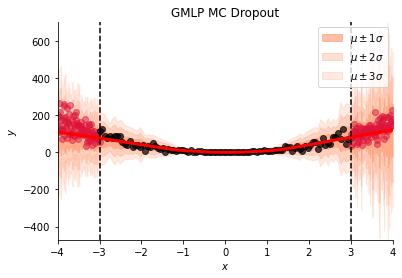

In [49]:
mc_mean, mc_sigma= mc_mean.reshape(n_points),mc_sigma.reshape(n_points)
plot.plot_prediction(X,y,x_stack,y_stack,mc_mean,mc_sigma,'GMLP MC Dropout')

## Deep Ensemble Gaussian MLP

In [63]:
auxs ={
    "X": X,
    "y": y,
    "deterministic" : True
}

In [153]:
params_list = []
losses_list = []
n_models = 3
for i in range(3):
    params = gmlp_model.init(jax.random.PRNGKey(i), auxs['X'], deterministic = True)
    params, loss =  fit(gmlp_model, params, auxs, learning_rate=0.003, epochs=2000, verbose=False)
    params_list.append(params)
    losses_list.append(loss)


In [154]:
means_list,sigmas_list = predict(n_models, gmlp_model, params_list, x_stack)
de_mean, de_sigma = gmm_mean_var(means_list,sigmas_list)

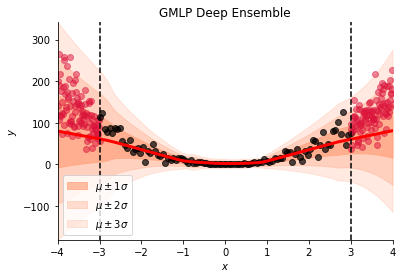

In [155]:
de_mean, de_sigma = de_mean.reshape(n_points),de_sigma.reshape(n_points)
plot.plot_prediction(X,y,x_stack,y_stack,de_mean,de_sigma,'GMLP Deep Ensemble')

In [59]:
key = jax.random.PRNGKey(42)
sigmaf = 5.0
len_scale =  3.0
kernel = GPy.kern.RBF(1, sigmaf, len_scale)



In [60]:
# %%capture
model_gp = GPy.models.GPRegression(X, y, kernel, normalizer=False) 
model_gp.Gaussian_noise = 1.0
model_gp.optimize(messages=True)
model_gp.optimize_restarts(num_restarts=5)



Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0006   2.544771e+03   8.841268e+04 
    00s04  0009   1.417763e+03   7.456116e+03 
    00s05  0013   6.753584e+02   4.757912e+02 
    00s08  0019   4.699711e+02   2.836348e+01 
    00s18  0040   4.093668e+02   7.195767e-01 
    00s19  0043   4.087691e+02   1.807187e-02 
    00s26  0069   4.077288e+02   7.596747e-09 
Runtime:     00s26
Optimization status: Converged

Optimization restart 1/5, f = 407.72882080078125
Optimization restart 2/5, f = 413.23974609375


 /home/summer2022/miniconda3/envs/env-00/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 3/5, f = 407.72882080078125
Optimization restart 4/5, f = 407.72882080078125
Optimization restart 5/5, f = 428.77734375


In [61]:
%%capture
mu_gp, cov_gp = model_gp.predict(x_stack)
mu_gp=mu_gp.reshape(n_points)
sigma_gp= jnp.sqrt(cov_gp).reshape(n_points)

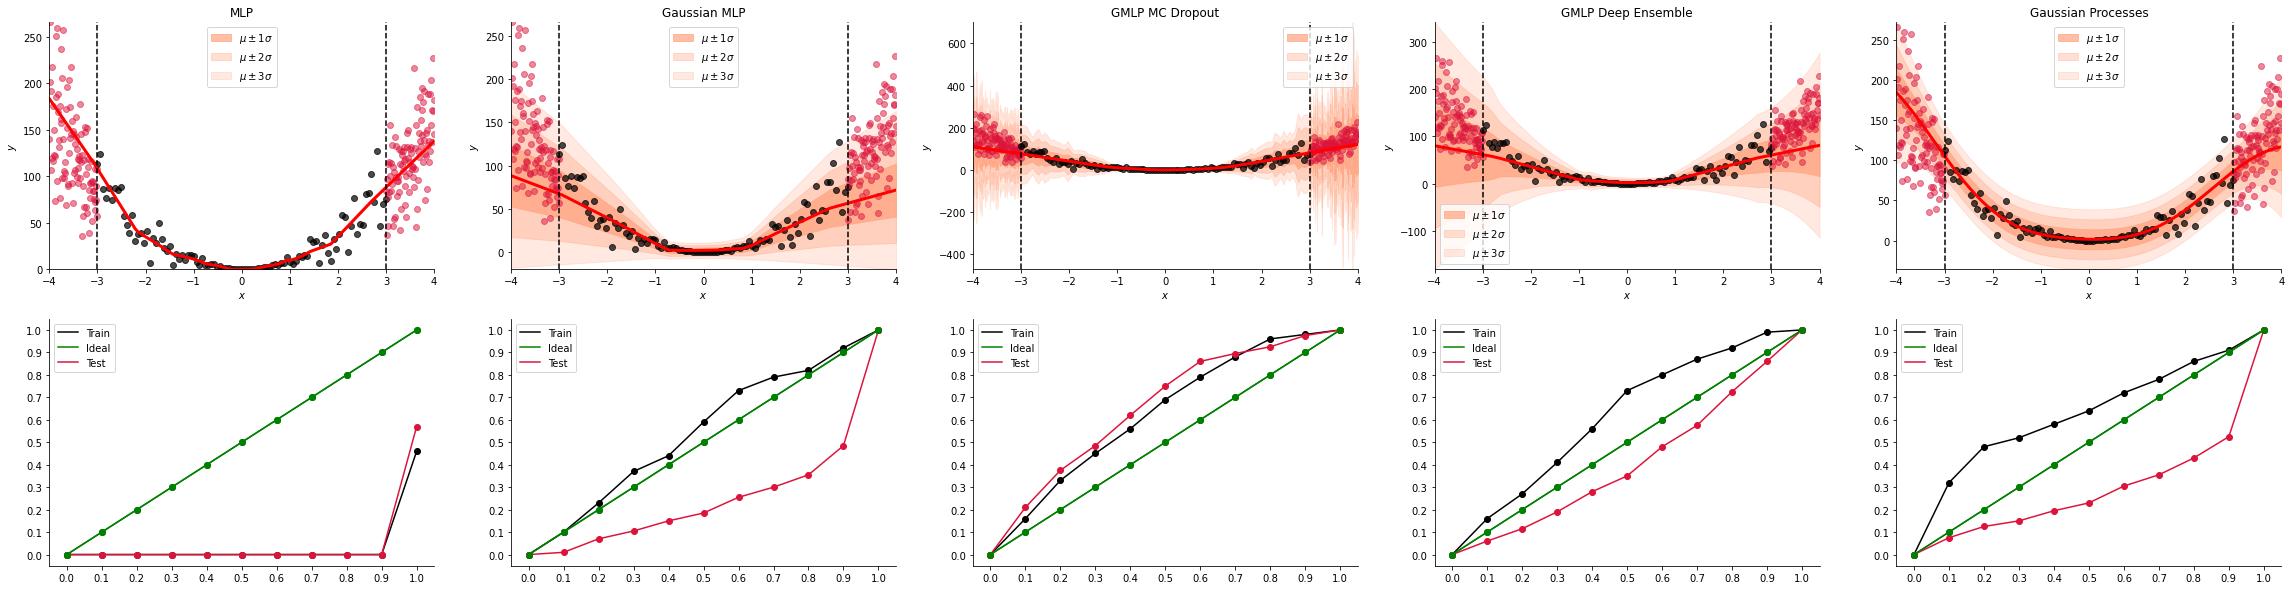

In [158]:
fig, ax = plt.subplots(2, 5, figsize=(40, 10))
plot.plot_prediction(X,y,x_stack,y_stack,y_hat,0,'MLP',ax[0][0])
plot.plot_prediction(X,y,x_stack,y_stack,gmlp_mean,gmlp_sigma,'Gaussian MLP',ax[0][1])
plot.plot_prediction(X,y,x_stack,y_stack,mc_mean,mc_sigma,'GMLP MC Dropout',ax[0][2])
plot.plot_prediction(X,y,x_stack,y_stack,de_mean,de_sigma,'GMLP Deep Ensemble',ax[0][3])
plot.plot_prediction(X,y,x_stack,y_stack,mu_gp,sigma_gp,'Gaussian Processes',ax[0][4])
plot.calibration_reg(y_hat,jnp.zeros(300),y_stack,ax[1][0])
plot.calibration_reg(gmlp_mean,gmlp_sigma,y_stack,ax[1][1])
plot.calibration_reg(mc_mean,mc_sigma,y_stack,ax[1][2])
plot.calibration_reg(de_mean,de_sigma,y_stack,ax[1][3])
plot.calibration_reg(mu_gp,sigma_gp,y_stack,ax[1][4])
plt.savefig('PolyHetero.pdf')
